In [12]:
import os

def load_yolo_boxes(yolo_txt_path: str, image_shape: tuple) -> np.ndarray:
    """
    Convert YOLO-formatted annotations into a binary mask.
    """
    h_img, w_img = image_shape[:2]
    mask = np.zeros((h_img, w_img), dtype=np.uint8)

    with open(yolo_txt_path, 'r') as file:
        lines = file.readlines()

    for i, line in enumerate(lines):
        parts = list(map(float, line.strip().split()))
        _, x_center, y_center, width, height = parts

        x_center_px = int(x_center * w_img)
        y_center_px = int(y_center * h_img)
        width_px = int(width * w_img)
        height_px = int(height * h_img)

        x1 = max(0, x_center_px - width_px // 2)
        y1 = max(0, y_center_px - height_px // 2)
        x2 = min(w_img, x_center_px + width_px // 2)
        y2 = min(h_img, y_center_px + height_px // 2)

        # Draw filled rectangle on mask for each box
        mask[y1:y2, x1:x2] = 255

    return mask



In [13]:
import matplotlib.pyplot as plt

def draw_masked_image(image: np.ndarray, mask: np.ndarray):
    """
    Overlay the binary mask on the image and display it.
    """
    masked_image = image.copy()
    masked_image[mask == 255] = [255, 0, 0]  # Highlight masked area in red

    plt.imshow(masked_image)
    plt.title("Image with Mask Overlay")
    plt.axis("off")
    plt.show()
    plt.imsave("masked.png", masked_image)

# Example usage (simulate a test if image/mask were present)
# dummy_image = np.ones((256, 256, 3), dtype=np.uint8) * 255
# dummy_mask = np.zeros((256, 256), dtype=np.uint8)
# dummy_mask[50:100, 50:100] = 255
# draw_masked_image(dummy_image, dummy_mask)



In [14]:
import cv2
import numpy as np

def precise_mask_from_yolo(image: np.ndarray, yolo_txt_path: str, threshold_type="adaptive") -> np.ndarray:
    """
    Create a precise global mask from YOLO boxes by thresholding inside each box.
    Assumes one bacterium per box and that bacteria are darker than background.
    """
    h_img, w_img = image.shape[:2]
    mask = np.zeros((h_img, w_img), dtype=np.uint8)

    with open(yolo_txt_path, 'r') as file:
        lines = file.readlines()

    for i, line in enumerate(lines):
        parts = list(map(float, line.strip().split()))
        _, x_center, y_center, width, height = parts

        x_center_px = int(x_center * w_img)
        y_center_px = int(y_center * h_img)
        width_px = int(width * w_img)
        height_px = int(height * h_img)

        x1 = max(0, x_center_px - width_px // 2)
        y1 = max(0, y_center_px - height_px // 2)
        x2 = min(w_img, x_center_px + width_px // 2)
        y2 = min(h_img, y_center_px + height_px // 2)

        roi = image[y1:y2, x1:x2]
        gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

        if threshold_type == "adaptive":
            thresh = cv2.adaptiveThreshold(
                gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                cv2.THRESH_BINARY_INV, 11, 2
            )
        else:
            _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Find largest contour (assumed to be the bacterium)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            local_mask = np.zeros_like(thresh)
            cv2.drawContours(local_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

            # Place it back in the global mask
            mask[y1:y2, x1:x2] = np.maximum(mask[y1:y2, x1:x2], local_mask)

    return mask



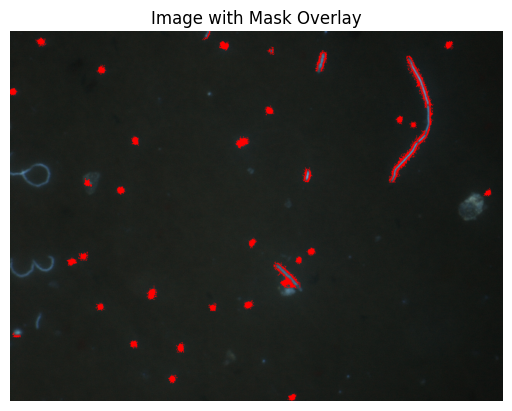

          xmm       ymm  powierzchniamm  długośćmm  szerokośćmm        kąt  \
0   51.212371  1.239175            0.97   3.288374     0.804115 -38.747404   
1    8.026433  2.773248            3.14   2.343976     2.039380  69.566934   
2   55.560052  3.737371            3.88   2.561041     2.095502  68.210711   
3  113.920979  3.566434            2.86   2.280363     1.868710 -46.329522   
4   67.824427  5.122901            1.31   2.061893     1.798550   4.748784   

     obwódmm  obwód_c.mm  średnica_fereta_hmm  średnica_fereta_vmm  \
0   6.452691    6.452691                  2.0                  2.4   
1  11.301829   11.301829                  2.8                  2.5   
2  10.319596   10.319596                  2.5                  2.5   
3  10.233200   10.233200                  2.4                  2.2   
4   8.811880    8.811880                  1.9                  2.2   

   średn._martinamm  średn._sitowamm  średnia_jaskrawość    r    g    b  \
0          1.644187         1.11132

In [15]:
from PIL import Image

# Parameters
image_path = "a1.jpg"
yolo_txt_path = "a1.txt"
# yolo_txt_path = "a1_small.txt"
pixel_to_mm = 0.1  # example: 1 pixel = 0.1 mm

# Load image
image = np.array(Image.open(image_path).convert("RGB"))

# Create mask from YOLO boxes
# mask = load_yolo_boxes(yolo_txt_path, image.shape)

mask = precise_mask_from_yolo(image, yolo_txt_path, threshold_type="adaptive")


draw_masked_image(image,mask)

# # Extract features
df = extract_bacteria_features_better(image, mask, pixel_to_mm)

# # Show or save results
print(df.head())
df.to_csv("bacteria_features.csv", index=False)
